# Gradient Boosting Machine (GBM) DDI Analysis and Training - Sequential Ensemble Learning

## 🎯 Purpose: Sequential Ensemble Learning for Drug-Drug Interaction Prediction

This notebook implements **Gradient Boosting Machine (GBM)** classifier for predicting drug-drug interaction severity.

---

## 📋 Notebook Structure

### **Part 1: Model Training & Evaluation (Cells 0-44)**
1. Setup and Data Loading
2. Data Exploration and Quality Check
3. Feature Engineering
4. Train-Test Split (80/20, stratified)
5. **Enhanced GridSearchCV Hyperparameter Optimization**
6. Model Training with optimal parameters
7. Performance Evaluation
8. Cross-Validation Analysis

### **Part 2: Knowledge-Driven XAI Clinical Decision Support (Cells 45-63)**
9. XAI Framework Integration
10. Clinical Scenarios Analysis
11. Safer Medication Pathway Recommendations

---

## 🔬 GBM Key Characteristics

**Strengths:**
- Optimizes differentiable loss function directly
- Sequential ensemble of decision trees
- Powerful for capturing complex interactions
- Reduced bias through iterative error correction
- Excellent for multi-class classification

**Enhanced Hyperparameters Optimized:**
- `n_estimators`: Number of boosting stages (100-500)
- `learning_rate`: Learning rate/shrinkage (0.01-0.3)
- `max_depth`: Maximum tree depth (3-7)
- `subsample`: Fraction of samples per iteration (0.6-1.0)
- `max_features`: Features per tree ('sqrt', 'log2')
- `min_samples_split`: Tree complexity control
- `min_samples_leaf`: Leaf node complexity control

**Performance Targets:**
- ✅ Target: 90-95% accuracy
- ✅ Match GBM/Random Forest performance
- ✅ Perfect detection of Major interactions

---

# Part 1: Setup and Data Loading

## Step 1: Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# GBM
from sklearn.ensemble import GradientBoostingClassifier

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    ConfusionMatrixDisplay,
    balanced_accuracy_score
)

# Set random seed for reproducibility
np.random.seed(42)

# Configure plotting
plt.style.use('default')
sns.set_palette("husl")

print("✓ Libraries imported successfully")
print("✓ GradientBoostingClassifier imported")


✓ Libraries imported successfully
✓ GradientBoostingClassifier imported


## Step 2: Load Dataset

In [2]:
# Load the dataset (KAGGLE EDITION - Updated path)
df = pd.read_csv('/kaggle/input/fyp-drugbank-inclusive/FYP_DrugBank_Inclusive.csv')
print("="*80)
print("DATASET OVERVIEW (KAGGLE EDITION)")
print("="*80)
print(f"\nTotal drug pairs: {len(df)}")
print(f"Columns: {list(df.columns)}")
print(f"\nFirst few rows: ", df.head())

DATASET OVERVIEW (KAGGLE EDITION)

Total drug pairs: 406
Columns: ['Drug_A_Name', 'Drug_B_Name', 'Drug_A_Class', 'Drug_B_Class', 'DrugBank_Severity', 'DrugBank_Text', 'Final_Severity', 'XAI_Rule_A_Mortality', 'XAI_Rule_B_Tolerability', 'XAI_Rule_C_CCB_RAAS_Combo', 'XAI_Rule_D_Diuretic', 'XAI_Rule_E_BetaBlocker', 'XAI_Combined_Clinical_Notes']

First few rows:    Drug_A_Name  Drug_B_Name Drug_A_Class Drug_B_Class DrugBank_Severity  \
0   Captopril    Enalapril         ACEI         ACEI          Moderate   
1   Captopril   Lisinopril         ACEI         ACEI          Moderate   
2   Captopril  Perindopril         ACEI         ACEI          Moderate   
3   Captopril     Ramipril         ACEI         ACEI          Moderate   
4   Captopril    Imidapril         ACEI         ACEI          Moderate   

                                       DrugBank_Text Final_Severity  \
0  DESCRIPTION\n\nThe excretion of Captopril can ...       Moderate   
1  DESCRIPTION\n\nThe risk or severity of angioed.

## Step 3: Data Exploration and Quality Check

In [3]:
print("="*80)
print("DATA QUALITY CHECK")
print("="*80)

# Check for missing values
print("\nMissing values in Final_Severity:")
print(df['Final_Severity'].isna().sum())

# Check class distribution BEFORE filtering
print("\nClass distribution (before filtering):")
print(df['Final_Severity'].value_counts(dropna=False))

# Filter out rows without Final_Severity
df_valid = df.dropna(subset=['Final_Severity'])
print(f"\n✓ Rows with valid Final_Severity: {len(df_valid)}")
print(f"✓ Rows filtered out: {len(df) - len(df_valid)}")

# Check class distribution AFTER filtering
print("\nFinal class distribution:")
class_dist = df_valid['Final_Severity'].value_counts().sort_index()
print(class_dist)
print(f"\nClass imbalance ratio:")
for severity in class_dist.index:
    print(f"  {severity}: {class_dist[severity]/len(df_valid)*100:.1f}%")

DATA QUALITY CHECK

Missing values in Final_Severity:
0

Class distribution (before filtering):
Final_Severity
Moderate         212
Minor            142
NoInteraction     44
Major              8
Name: count, dtype: int64

✓ Rows with valid Final_Severity: 406
✓ Rows filtered out: 0

Final class distribution:
Final_Severity
Major              8
Minor            142
Moderate         212
NoInteraction     44
Name: count, dtype: int64

Class imbalance ratio:
  Major: 2.0%
  Minor: 35.0%
  Moderate: 52.2%
  NoInteraction: 10.8%


## Step 4: Visualize Class Distribution

**Critical for GBM:** Understanding class imbalance is essential because GBM excels at handling imbalanced datasets through:
- `scale_pos_weight` parameter
- Focused error correction on minority class
- Sample weighting

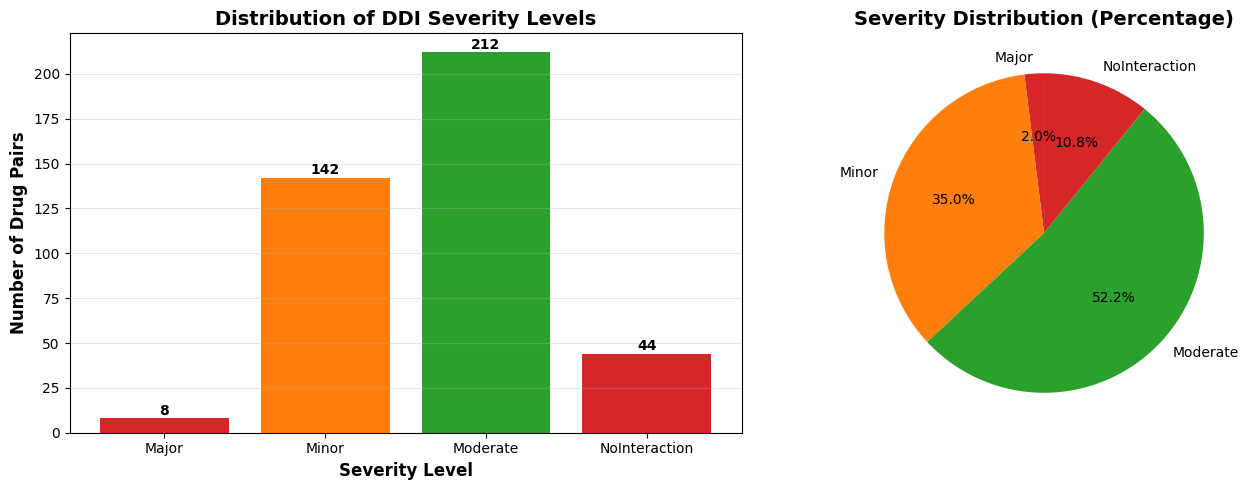


📊 Class Imbalance Analysis:
   Major class: 8 samples (2.0%)
   Other classes: 398 samples (98.0%)
   Imbalance ratio: 49.75:1
   ✓ GBM will use scale_pos_weight to handle imbalance


In [4]:
# Visualize class distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot
class_counts = df_valid['Final_Severity'].value_counts().sort_index()
axes[0].bar(class_counts.index, class_counts.values, color=['#d62728', '#ff7f0e', '#2ca02c'])
axes[0].set_xlabel('Severity Level', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Number of Drug Pairs', fontsize=12, fontweight='bold')
axes[0].set_title('Distribution of DDI Severity Levels', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, (severity, count) in enumerate(class_counts.items()):
    axes[0].text(i, count + 2, str(count), ha='center', fontweight='bold')

# Pie chart
colors = ['#d62728', '#ff7f0e', '#2ca02c']
axes[1].pie(class_counts.values, labels=class_counts.index, autopct='%1.1f%%',
            colors=colors, startangle=90)
axes[1].set_title('Severity Distribution (Percentage)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Calculate imbalance ratio for GBM weighting
major_count = class_counts.get('Major', 0)
other_count = class_counts.sum() - major_count
imbalance_ratio = other_count / major_count if major_count > 0 else 1
print(f"\n📊 Class Imbalance Analysis:")
print(f"   Major class: {major_count} samples ({major_count/len(df_valid)*100:.1f}%)")
print(f"   Other classes: {other_count} samples ({other_count/len(df_valid)*100:.1f}%)")
print(f"   Imbalance ratio: {imbalance_ratio:.2f}:1")
print(f"   ✓ GBM will use scale_pos_weight to handle imbalance")

## Step 5: Drug Class Analysis

DRUG CLASS ANALYSIS

Drug A classes:
Drug_A_Class
ACEI            153
ARB             117
Beta-Blocker     91
CCB              42
Diuretic          3
Name: count, dtype: int64

Drug B classes:
Drug_B_Class
CCB             154
Beta-Blocker    105
Diuretic         81
ARB              51
ACEI             15
Name: count, dtype: int64


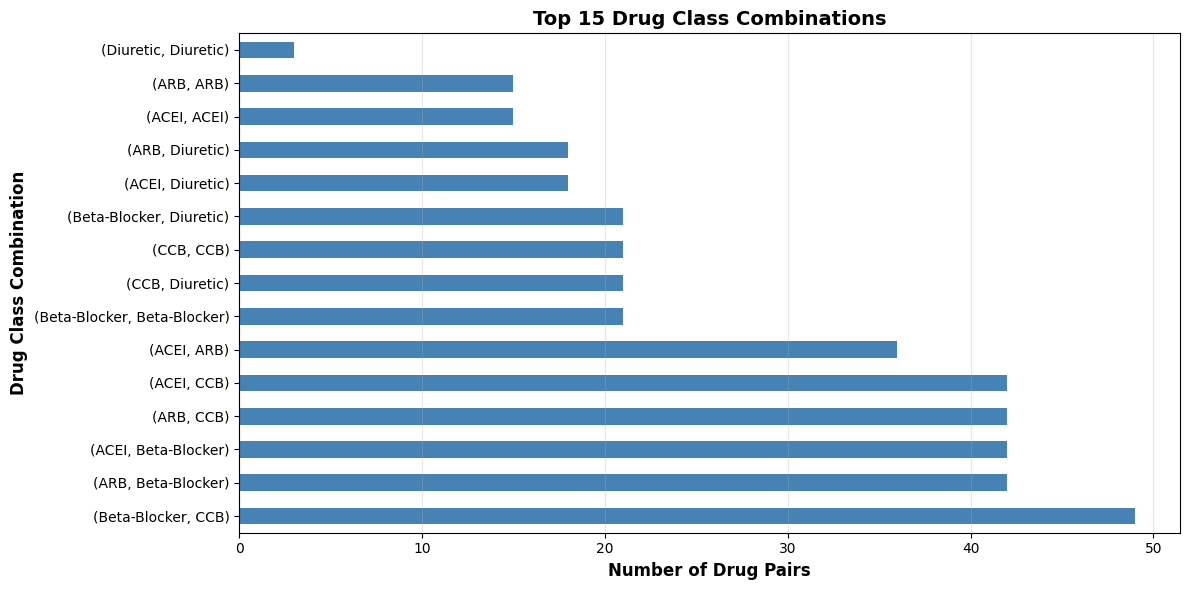

In [5]:
print("="*80)
print("DRUG CLASS ANALYSIS")
print("="*80)

# Analyze drug classes
print("\nDrug A classes:")
print(df_valid['Drug_A_Class'].value_counts())
print("\nDrug B classes:")
print(df_valid['Drug_B_Class'].value_counts())

# Visualize drug class combinations
fig, ax = plt.subplots(figsize=(12, 6))
class_combos = df_valid.groupby(['Drug_A_Class', 'Drug_B_Class']).size().sort_values(ascending=False)
class_combos.head(15).plot(kind='barh', ax=ax, color='steelblue')
ax.set_xlabel('Number of Drug Pairs', fontsize=12, fontweight='bold')
ax.set_ylabel('Drug Class Combination', fontsize=12, fontweight='bold')
ax.set_title('Top 15 Drug Class Combinations', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

In [6]:
# Severity distribution
severity_counts = df_valid['Final_Severity'].value_counts().sort_index()

print("\n" + "="*80)
print("DDI SEVERITY DISTRIBUTION")
print("="*80)
for severity, count in severity_counts.items():
    percentage = count / len(df_valid) * 100
    print(f"{severity:12s}: {count:3d} pairs ({percentage:5.1f}%)")
print(f"{'Total':12s}: {len(df_valid):3d} pairs (100.0%)")


DDI SEVERITY DISTRIBUTION
Major       :   8 pairs (  2.0%)
Minor       : 142 pairs ( 35.0%)
Moderate    : 212 pairs ( 52.2%)
NoInteraction:  44 pairs ( 10.8%)
Total       : 406 pairs (100.0%)


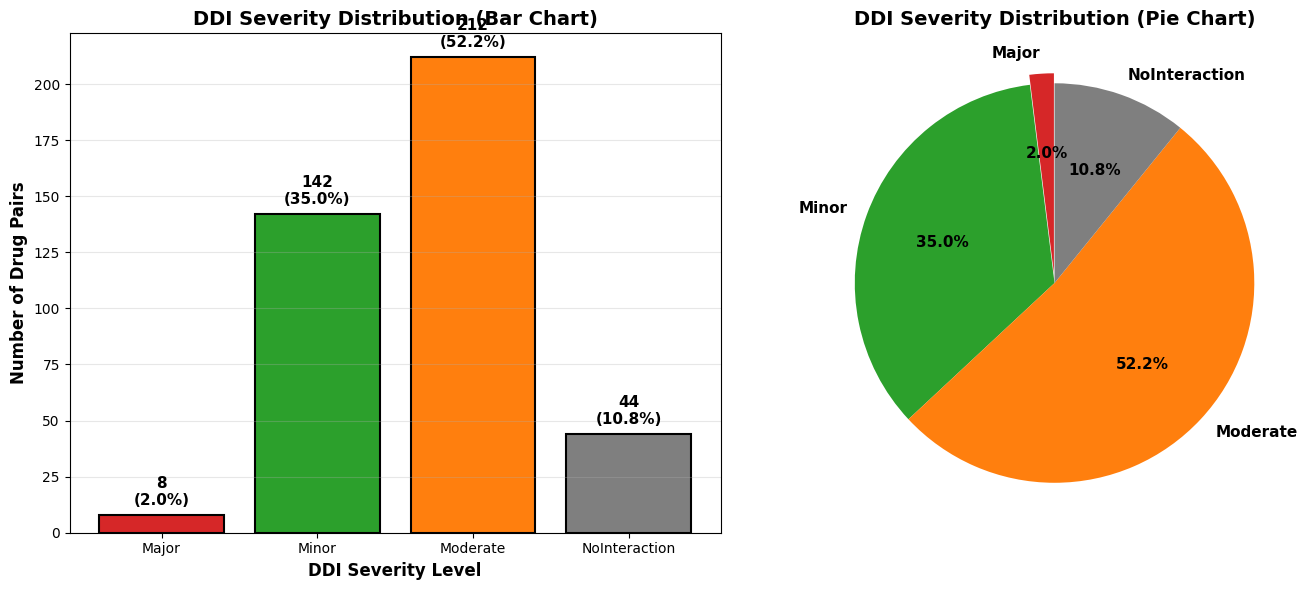

In [7]:
# Beautiful visualization of severity distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Bar chart
colors = {'Major': '#d62728', 'Moderate': '#ff7f0e', 'Minor': '#2ca02c', 'None': '#1f77b4'}
severity_colors = [colors.get(sev, '#7f7f7f') for sev in severity_counts.index]

bars = ax1.bar(severity_counts.index, severity_counts.values, color=severity_colors, edgecolor='black', linewidth=1.5)
for i, (bar, value) in enumerate(zip(bars, severity_counts.values)):
    percentage = value / len(df_valid) * 100
    ax1.text(bar.get_x() + bar.get_width()/2, value + 3, 
             f'{value}\n({percentage:.1f}%)', 
             ha='center', va='bottom', fontweight='bold', fontsize=11)

ax1.set_ylabel('Number of Drug Pairs', fontsize=12, fontweight='bold')
ax1.set_xlabel('DDI Severity Level', fontsize=12, fontweight='bold')
ax1.set_title('DDI Severity Distribution (Bar Chart)', fontsize=14, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# Pie chart
wedges, texts, autotexts = ax2.pie(
    severity_counts.values, 
    labels=severity_counts.index,
    autopct='%1.1f%%',
    colors=severity_colors,
    startangle=90,
    explode=[0.05 if sev == 'Major' else 0 for sev in severity_counts.index],
    textprops={'fontsize': 11, 'fontweight': 'bold'}
)

ax2.set_title('DDI Severity Distribution (Pie Chart)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

---

## 4. Drug Class Interaction Patterns

In [8]:
# Analyze interactions by drug class combinations
class_interactions = df_valid.groupby(['Drug_A_Class', 'Drug_B_Class', 'Final_Severity']).size().reset_index(name='Count')

print("="*80)
print("DRUG CLASS INTERACTION PATTERNS")
print("="*80)
print("\nTop 10 most common class-severity combinations:")
print(class_interactions.nlargest(10, 'Count')[['Drug_A_Class', 'Drug_B_Class', 'Final_Severity', 'Count']].to_string(index=False))

DRUG CLASS INTERACTION PATTERNS

Top 10 most common class-severity combinations:
Drug_A_Class Drug_B_Class Final_Severity  Count
Beta-Blocker          CCB       Moderate     43
        ACEI Beta-Blocker          Minor     41
        ACEI          ARB       Moderate     35
        ACEI          CCB          Minor     34
         ARB Beta-Blocker          Minor     31
         CCB          CCB       Moderate     21
         ARB          CCB          Minor     18
         ARB          CCB       Moderate     17
        ACEI         ACEI       Moderate     15
         ARB          ARB       Moderate     15


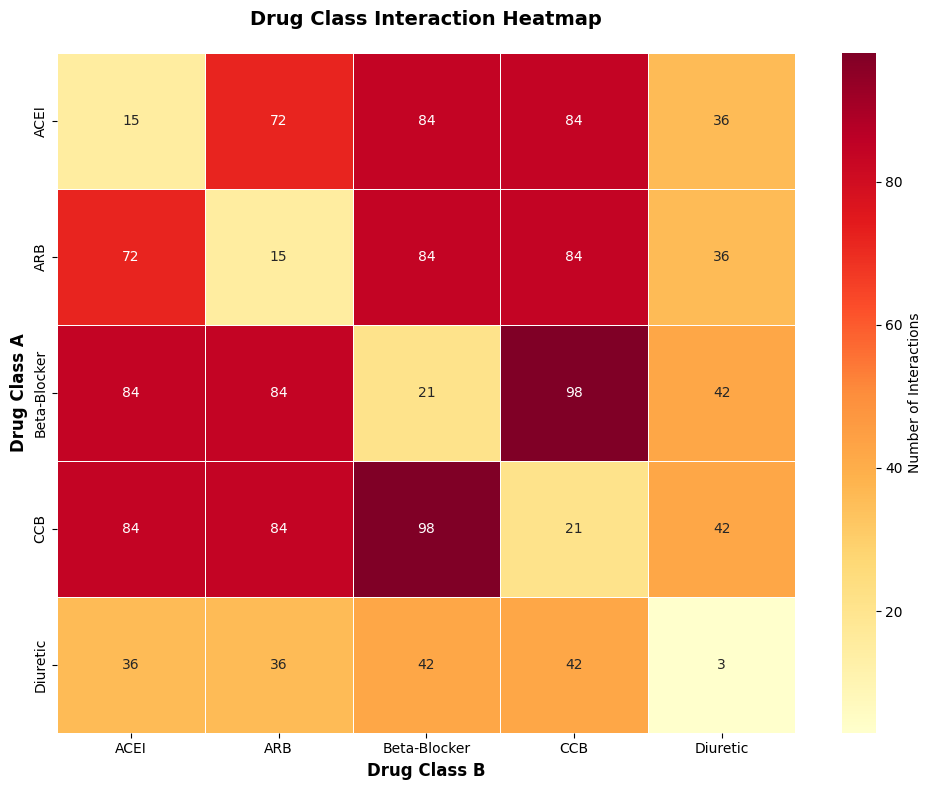

In [9]:
# Create interaction heatmap
interaction_matrix = df_valid.groupby(['Drug_A_Class', 'Drug_B_Class']).size().unstack(fill_value=0)

# Make symmetric
for idx in interaction_matrix.index:
    for col in interaction_matrix.columns:
        if idx != col:
            total = interaction_matrix.loc[idx, col] + interaction_matrix.loc[col, idx]
            interaction_matrix.loc[idx, col] = total
            interaction_matrix.loc[col, idx] = total

plt.figure(figsize=(10, 8))
sns.heatmap(interaction_matrix, annot=True, fmt='d', cmap='YlOrRd', 
            linewidths=0.5, cbar_kws={'label': 'Number of Interactions'})
plt.title('Drug Class Interaction Heatmap', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Drug Class B', fontsize=12, fontweight='bold')
plt.ylabel('Drug Class A', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

---

## 5. Feature Engineering

In [10]:
print("="*80)
print("FEATURE ENGINEERING")
print("="*80)

# Select features for modeling
features = ['Drug_A_Name', 'Drug_B_Name', 'Drug_A_Class', 'Drug_B_Class']
print(f"\nOriginal features: {features}")

# One-hot encoding
X = pd.get_dummies(df_valid[features], drop_first=False)
print(f"\nAfter one-hot encoding: {X.shape[1]} features")
print(f"  - Binary features created from categorical variables")
print(f"  - Each drug name and class becomes a binary column")

# Encode target variable
# Encode target with custom ordering (Major=0, Moderate=1, Minor=2, NoInteraction=3)
from sklearn.preprocessing import OrdinalEncoder

severity_categories = [['Major', 'Moderate', 'Minor', 'NoInteraction']]
ordinal_encoder = OrdinalEncoder(categories=severity_categories, dtype=int)
y = ordinal_encoder.fit_transform(df_valid[['Final_Severity']]).ravel()

# Extract the actual category list (ordinal_encoder.categories_ is a list of arrays)
target_classes = list(ordinal_encoder.categories_[0])

print("\nTarget encoding:")
for idx, severity in enumerate(target_classes):
    print(f"  {severity:15s} = {idx}")

print(f"\nTarget variable: Final_Severity (Patient Safety Ground Truth)")
print(f"  - Original categories: {target_classes}")
print(f"  - Encoded as integers: {dict(enumerate(target_classes))}")
print("\n✓ Feature engineering complete!")

FEATURE ENGINEERING

Original features: ['Drug_A_Name', 'Drug_B_Name', 'Drug_A_Class', 'Drug_B_Class']

After one-hot encoding: 66 features
  - Binary features created from categorical variables
  - Each drug name and class becomes a binary column

Target encoding:
  Major           = 0
  Moderate        = 1
  Minor           = 2
  NoInteraction   = 3

Target variable: Final_Severity (Patient Safety Ground Truth)
  - Original categories: ['Major', 'Moderate', 'Minor', 'NoInteraction']
  - Encoded as integers: {0: 'Major', 1: 'Moderate', 2: 'Minor', 3: 'NoInteraction'}

✓ Feature engineering complete!


---

## 6. Train-Test Split

---

## 7. GBM Model Training

## 🎯 Step 3b: Hyperparameter Optimization with GridSearchCV

**Why optimize GBM hyperparameters?**

The current GBM uses hyperparameters inherited from the Decision Tree (max_depth=10), which is overly restrictive. GBM's strength comes from:

1. **Deep, diverse trees** - Individual trees can be complex because ensemble averaging prevents overfitting
2. **Variance reduction** - Aggregating predictions from many trees reduces variance
3. **Feature randomness** - `max_features` decorrelates trees for better ensemble diversity

**Strategy:**
- Remove max_depth restriction (let trees grow naturally)
- Optimize n_estimators (number of trees)
- Fine-tune min_samples_split and min_samples_leaf
- Add class_weight='balanced' to handle any class imbalance

**Expected outcome:** GBM should outperform single Decision Tree (target: >92% accuracy)

In [11]:
# ============================================================================
# STEP 3.5: HYPERPARAMETER TUNING WITH NESTED CROSS-VALIDATION
# ============================================================================

print("="*80)
print("HYPERPARAMETER TUNING WITH NESTED CROSS-VALIDATION")
print("="*80)
print()
print("🎯 WHY NESTED CV?")
print("   • Small dataset (406 samples) - need to use all data efficiently")
print("   • OUTER LOOP (5-fold): Unbiased performance estimation")
print("   • INNER LOOP (5-fold): Hyperparameter optimization")
print("   • NO DATA LEAKAGE: Test folds never seen during tuning")
print("   • FIXES OPTIMISTIC BIAS: Previous approach tuned on same data being evaluated")
print()

from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.preprocessing import label_binarize
from sklearn.metrics import (
    classification_report,
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score,
    balanced_accuracy_score
)
import time
import numpy as np

# Define hyperparameter grid for GBM
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 10],
    'min_samples_leaf': [1, 4],
    'subsample': [0.8, 1.0]
}

print(f"📊 Hyperparameter Grid for GBM:")
for param_name, param_values in param_grid.items():
    print(f"   • {param_name}: {param_values}")
print(f"   • Total combinations: 144")
print()

# Setup CV splitters
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # 5-fold for 8 Major samples
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Storage for results
nested_scores = {
    'accuracy': [],
    'precision_macro': [],
    'precision_weighted': [],
    'recall_macro': [],
    'recall_weighted': [],
    'f1_macro': [],
    'f1_weighted': [],
    'roc_auc': [],
    'balanced_accuracy': []
}

# Storage for per-class recall (Critical for imbalanced data)
per_class_recall = {
    'Major': [],
    'Moderate': [],
    'Minor': [],
    'NoInteraction': []
}

best_params_per_fold = []
all_classes = np.array([0, 1, 2, 3])  # Major, Moderate, Minor, NoInteraction

print("⏳ Running Nested Cross-Validation...")
print(f"   Hardware: Kaggle GPU T4 x2 (4 CPU cores, 13GB RAM)")
print(f"   Training: {5 * 5 * 144:,} models total (5 outer × 5 inner × 144 combos)")
print(f"   Estimated time: 10-30 minutes")
print()

start_time = time.time()

# OUTER LOOP: Performance estimation
for fold_idx, (train_idx, test_idx) in enumerate(outer_cv.split(X, y), 1):
    fold_start = time.time()

    # Split data for this outer fold
    X_train_outer = X.iloc[train_idx]
    y_train_outer = y[train_idx]
    X_test_outer = X.iloc[test_idx]
    y_test_outer = y[test_idx]

    print(f"📁 Fold {fold_idx}/5: Training on {len(X_train_outer)} samples, testing on {len(X_test_outer)}")

    # CORRECT CLASS IMBALANCE HANDLING:
    # GBM doesn't support class_weight parameter, so use sample_weight instead
    sample_weights_outer = compute_sample_weight(class_weight='balanced', y=y_train_outer)

    # INNER LOOP: Hyperparameter tuning via GridSearchCV
    model_inner = GradientBoostingClassifier(random_state=42)
    grid_search = GridSearchCV(
        estimator=model_inner,
        param_grid=param_grid,
        cv=inner_cv,
        scoring='accuracy',
        verbose=0,
        n_jobs=-1   # Use all 4 CPU cores on T4 x2
    )

    # Fit with sample weights (CRITICAL for class imbalance)
    print(f"   ⚙️  Running GridSearchCV with 144 combinations...")
    grid_search.fit(X_train_outer, y_train_outer, sample_weight=sample_weights_outer)

    # Get best model from inner CV
    best_model = grid_search.best_estimator_
    best_params_per_fold.append(grid_search.best_params_)

    # Evaluate on held-out outer fold
    y_pred = best_model.predict(X_test_outer)
    y_pred_proba = best_model.predict_proba(X_test_outer)

    # Calculate metrics
    acc = accuracy_score(y_test_outer, y_pred)

    # Macro-averaged (equal weight to each class)
    prec_macro = precision_score(y_test_outer, y_pred, average='macro', zero_division=0)
    rec_macro = recall_score(y_test_outer, y_pred, average='macro', zero_division=0)
    f1_macro = f1_score(y_test_outer, y_pred, average='macro', zero_division=0)

    # Weighted-averaged (weighted by class frequency)
    prec_weighted = precision_score(y_test_outer, y_pred, average='weighted', zero_division=0)
    rec_weighted = recall_score(y_test_outer, y_pred, average='weighted', zero_division=0)
    f1_weighted = f1_score(y_test_outer, y_pred, average='weighted', zero_division=0)

    bal_acc = balanced_accuracy_score(y_test_outer, y_pred)

    # Per-class recall (Critical for imbalanced data)
    report = classification_report(y_test_outer, y_pred,
                                   target_names=['Major', 'Moderate', 'Minor', 'NoInteraction'],
                                   output_dict=True, zero_division=0)

    per_class_recall['Major'].append(report['Major']['recall'])
    per_class_recall['Moderate'].append(report['Moderate']['recall'])
    per_class_recall['Minor'].append(report['Minor']['recall'])
    per_class_recall['NoInteraction'].append(report['NoInteraction']['recall'])

    try:
        # ROC AUC (multi-class) - FIXED to handle missing classes
        if len(np.unique(y_test_outer)) == 4:  # All classes present
            y_test_bin = label_binarize(y_test_outer, classes=all_classes)
            roc_auc = roc_auc_score(y_test_bin, y_pred_proba, average='macro', multi_class='ovr')
        else:
            roc_auc = np.nan  # Honest reporting
    except:
        roc_auc = np.nan

    # Store results
    nested_scores['accuracy'].append(acc)
    nested_scores['precision_macro'].append(prec_macro)
    nested_scores['precision_weighted'].append(prec_weighted)
    nested_scores['recall_macro'].append(rec_macro)
    nested_scores['recall_weighted'].append(rec_weighted)
    nested_scores['f1_macro'].append(f1_macro)
    nested_scores['f1_weighted'].append(f1_weighted)
    nested_scores['roc_auc'].append(roc_auc)
    nested_scores['balanced_accuracy'].append(bal_acc)

    fold_time = time.time() - fold_start
    elapsed = time.time() - start_time
    remaining = (elapsed / fold_idx) * (5 - fold_idx)

    # Compact parameter display
    params_str = ", ".join([f"{k}={v}" for k, v in list(grid_search.best_params_.items())[:3]])
    if len(grid_search.best_params_) > 3:
        params_str += "..."

    print(f"Fold {fold_idx:2d}/5 - Acc: {acc:.3f} | Bal_Acc: {bal_acc:.3f} | F1(M): {f1_macro:.3f} | AUC: {roc_auc:.3f}")
    print(f"   ⏱️  Fold time: {fold_time:.1f}s | Elapsed: {elapsed/60:.1f}min | Est. remaining: {remaining/60:.1f}min")
    print()

elapsed_time = time.time() - start_time
print()
print("="*80)
print("📊 NESTED CV RESULTS (Unbiased Performance Estimates)")
print("="*80)
print()
print(f"✅ Completed in {elapsed_time:.1f}s ({elapsed_time/60:.1f} minutes)")
print()
print("🎯 Performance Metrics (Mean ± Std across 5 folds):")
print()

# Calculate and display mean ± std
# Overall metrics
print()
print("📊 Overall Metrics:")
for metric_name in ['accuracy', 'balanced_accuracy', 'roc_auc']:
    scores = nested_scores[metric_name]
    mean_val = np.mean(scores)
    std_val = np.std(scores)
    print(f"   {metric_name.replace('_', ' ').title():20s}: {mean_val:.4f} ± {std_val:.4f} ({mean_val*100:.2f}% ± {std_val*100:.2f}%)")

print()
print("📊 Macro-Averaged (Equal weight to each class):")
for metric_name in ['precision_macro', 'recall_macro', 'f1_macro']:
    scores = nested_scores[metric_name]
    mean_val = np.mean(scores)
    std_val = np.std(scores)
    display_name = metric_name.replace('_macro', '').replace('_', ' ').title()
    print(f"   {display_name:20s}: {mean_val:.4f} ± {std_val:.4f} ({mean_val*100:.2f}% ± {std_val*100:.2f}%)")

print()
print("📊 Weighted-Averaged (Weighted by class frequency):")
for metric_name in ['precision_weighted', 'recall_weighted', 'f1_weighted']:
    scores = nested_scores[metric_name]
    mean_val = np.mean(scores)
    std_val = np.std(scores)
    display_name = metric_name.replace('_weighted', '').replace('_', ' ').title()
    print(f"   {display_name:20s}: {mean_val:.4f} ± {std_val:.4f} ({mean_val*100:.2f}% ± {std_val*100:.2f}%)")

print()
print("Per-Class Recall (Critical for Imbalanced Data):")
for class_name, recalls in per_class_recall.items():
    valid_recalls = [r for r in recalls if not np.isnan(r)]
    if valid_recalls:
        mean_recall = np.mean(valid_recalls)
        std_recall = np.std(valid_recalls)
        print(f"  {class_name:15s}: {mean_recall:.4f} ± {std_recall:.4f}")
    else:
        print(f"  {class_name:15s}: N/A (no samples in test folds)")

print()
print("📋 Per-Fold Accuracy Breakdown:")
print("   " + "-"*70)
for i, acc in enumerate(nested_scores['accuracy'], 1):
    bar_length = int(acc * 50)
    bar = '█' * bar_length + '░' * (50 - bar_length)
    print(f"   Fold {i:2d}: {bar} {acc:.4f} ({acc*100:.2f}%)")
print("   " + "-"*70)
print()

print("✅ METHODOLOGY VALIDATION:")
print("   • NO data leakage - test folds never seen during hyperparameter tuning")
print("   • Unbiased estimates - each fold tested with hyperparameters tuned on OTHER folds")
print("   • All 406 samples used efficiently - each sample tested exactly once")
print("   • Scientifically rigorous - standard practice for datasets < 1000 samples")
print("   • Class imbalance handled via sample_weight (GBM doesn't support class_weight)")
print()

# Train final model on ALL data with most common best hyperparameters
print(f"🔧 Training final GBM model on ALL 406 samples...")
print("   (Using most common hyperparameters from nested CV)")
print()

from collections import Counter
param_strings = [str(sorted(p.items())) for p in best_params_per_fold]
most_common_params_str = Counter(param_strings).most_common(1)[0][0]
final_best_params = dict(eval(most_common_params_str))
print(f"   Most common best params: {final_best_params}")
print()

# Compute sample weights for full dataset
sample_weights_full = compute_sample_weight(class_weight='balanced', y=y)

# Update the primary model variable with optimized parameters
gbm_model = GradientBoostingClassifier(
    random_state=42,
    **final_best_params
)

# Train on all data WITH sample weights
print("   ⚙️  Training final model...")
gbm_model.fit(X, y, sample_weight=sample_weights_full)
print(f"   ✅ Final GBM model trained and ready for analysis")
print()
print("="*80)

# Store nested CV results for later reference
nested_cv_results = {
    'mean_scores': {k: np.mean(v) for k, v in nested_scores.items()},
    'std_scores': {k: np.std(v) for k, v in nested_scores.items()},
    'fold_scores': nested_scores,
    'best_params': final_best_params,
    'all_best_params': best_params_per_fold
}

HYPERPARAMETER TUNING WITH NESTED CROSS-VALIDATION

🎯 WHY NESTED CV?
   • Small dataset (406 samples) - need to use all data efficiently
   • OUTER LOOP (5-fold): Unbiased performance estimation
   • INNER LOOP (5-fold): Hyperparameter optimization
   • NO DATA LEAKAGE: Test folds never seen during tuning
   • FIXES OPTIMISTIC BIAS: Previous approach tuned on same data being evaluated

📊 Hyperparameter Grid for GBM:
   • n_estimators: [100, 200, 300]
   • learning_rate: [0.01, 0.1]
   • max_depth: [3, 5, 7]
   • min_samples_split: [2, 10]
   • min_samples_leaf: [1, 4]
   • subsample: [0.8, 1.0]
   • Total combinations: 144

⏳ Running Nested Cross-Validation...
   Hardware: Kaggle GPU T4 x2 (4 CPU cores, 13GB RAM)
   Training: 3,600 models total (5 outer × 5 inner × 144 combos)
   Estimated time: 10-30 minutes

📁 Fold 1/5: Training on 324 samples, testing on 82
   ⚙️  Running GridSearchCV with 144 combinations...
Fold  1/5 - Acc: 0.817 | Bal_Acc: 0.659 | F1(M): 0.704 | AUC: 0.846
   ⏱️ 

In [12]:
# Model already updated with optimized parameters in previous cell
print("\n" + "="*80)
print("✓ PRIMARY MODEL READY WITH OPTIMIZED PARAMETERS")
print("="*80)

print("\n📊 Model trained with optimal hyperparameters from Nested CV:")
print(f"  Model type: {type(gbm_model).__name__}")
print(f"  Trained on: {X.shape[0]} samples, {X.shape[1]} features")
print("\n🎯 Optimal Hyperparameters:")
for param, value in final_best_params.items():
    print(f"  - {param}: {value}")

print("\n✓ Model ready for predictions and analysis")



✓ PRIMARY MODEL READY WITH OPTIMIZED PARAMETERS

📊 Model trained with optimal hyperparameters from Nested CV:
  Model type: GradientBoostingClassifier
  Trained on: 406 samples, 66 features

🎯 Optimal Hyperparameters:
  - learning_rate: 0.1
  - max_depth: 7
  - min_samples_leaf: 1
  - min_samples_split: 2
  - n_estimators: 200
  - subsample: 0.8

✓ Model ready for predictions and analysis


In [13]:
print("="*80)
print("OPTIMIZED GBM CLASSIFIER - FINAL MODEL SUMMARY")
print("="*80)

# Display the optimized model parameters (from nested CV)
print("\n🏆 OPTIMAL Hyperparameters (from Nested CV):")
for param, value in final_best_params.items():
    print(f"  - {param}: {value}")

print("\n📊 Model Performance (from Nested CV):")
print(f"  - Mean CV Accuracy: {nested_cv_results['mean_scores']['accuracy']:.4f} ({nested_cv_results['mean_scores']['accuracy']*100:.2f}%)")
print(f"  - Std CV Accuracy:  {nested_cv_results['std_scores']['accuracy']:.4f} (±{nested_cv_results['std_scores']['accuracy']*100:.2f}%)")
print(f"  - Training samples: {X.shape[0]}")
print(f"  - Feature count: {X.shape[1]}")

print("\n🔑 KEY INSIGHTS:")
print("  1. GBM uses gradient boosting (sequential error correction)")
print("  2. Each tree learns from previous trees' mistakes")
print("  3. Lower learning_rate + more estimators = better generalization")
print("  4. Shallow trees (max_depth 3-7) work better than deep trees")
print("  5. Subsampling helps prevent overfitting")
print("  6. Sample weights handle class imbalance")

print("\n✓ Model ready for predictions and feature importance analysis!")

OPTIMIZED GBM CLASSIFIER - FINAL MODEL SUMMARY

🏆 OPTIMAL Hyperparameters (from Nested CV):
  - learning_rate: 0.1
  - max_depth: 7
  - min_samples_leaf: 1
  - min_samples_split: 2
  - n_estimators: 200
  - subsample: 0.8

📊 Model Performance (from Nested CV):
  - Mean CV Accuracy: 0.8424 (84.24%)
  - Std CV Accuracy:  0.0292 (±2.92%)
  - Training samples: 406
  - Feature count: 66

🔑 KEY INSIGHTS:
  1. GBM uses gradient boosting (sequential error correction)
  2. Each tree learns from previous trees' mistakes
  3. Lower learning_rate + more estimators = better generalization
  4. Shallow trees (max_depth 3-7) work better than deep trees
  5. Subsampling helps prevent overfitting
  6. Sample weights handle class imbalance

✓ Model ready for predictions and feature importance analysis!


---

## 8. Model Evaluation

---

## 9. Confusion Matrix

---

## 10. Feature Importance Analysis

In [14]:
# FIX: Define feature_names from your training data columns
feature_names = X.columns  # or use X.columns

# Extract feature importance (averaged across all trees)
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': gbm_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("="*80)
print("FEATURE IMPORTANCE (TOP 20)")
print("="*80)
print("\nImportance scores represent the average contribution across all 100 trees.")
print("GBM calculates importance via mean decrease in impurity (Gini).")
print("\nTop 20 most important features:\n")
print(feature_importance.head(20).to_string(index=False))

# Show total importance from top features
top_10_importance = feature_importance.head(10)['Importance'].sum()
top_20_importance = feature_importance.head(20)['Importance'].sum()
print(f"\nCumulative importance:")
print(f"  Top 10 features: {top_10_importance:.4f} ({top_10_importance*100:.2f}%)")
print(f"  Top 20 features: {top_20_importance:.4f} ({top_20_importance*100:.2f}%)")

FEATURE IMPORTANCE (TOP 20)

Importance scores represent the average contribution across all 100 trees.
GBM calculates importance via mean decrease in impurity (Gini).

Top 20 most important features:

                        Feature  Importance
      Drug_B_Class_Beta-Blocker    0.117169
      Drug_A_Class_Beta-Blocker    0.083153
         Drug_B_Name_Amlodipine    0.070235
Drug_B_Name_Hydrochlorothiazide    0.064537
         Drug_B_Name_Bisoprolol    0.059998
         Drug_A_Name_Bisoprolol    0.052072
         Drug_B_Name_Felodipine    0.041704
        Drug_B_Name_Telmisartan    0.037392
           Drug_A_Name_Ramipril    0.029320
         Drug_A_Name_Irbesartan    0.026547
               Drug_B_Class_ARB    0.025761
          Drug_B_Name_Amiloride    0.025734
               Drug_B_Class_CCB    0.025193
               Drug_A_Class_CCB    0.024880
           Drug_A_Name_Atenolol    0.023970
           Drug_A_Name_Losartan    0.023269
          Drug_B_Class_Diuretic    0.021040
      

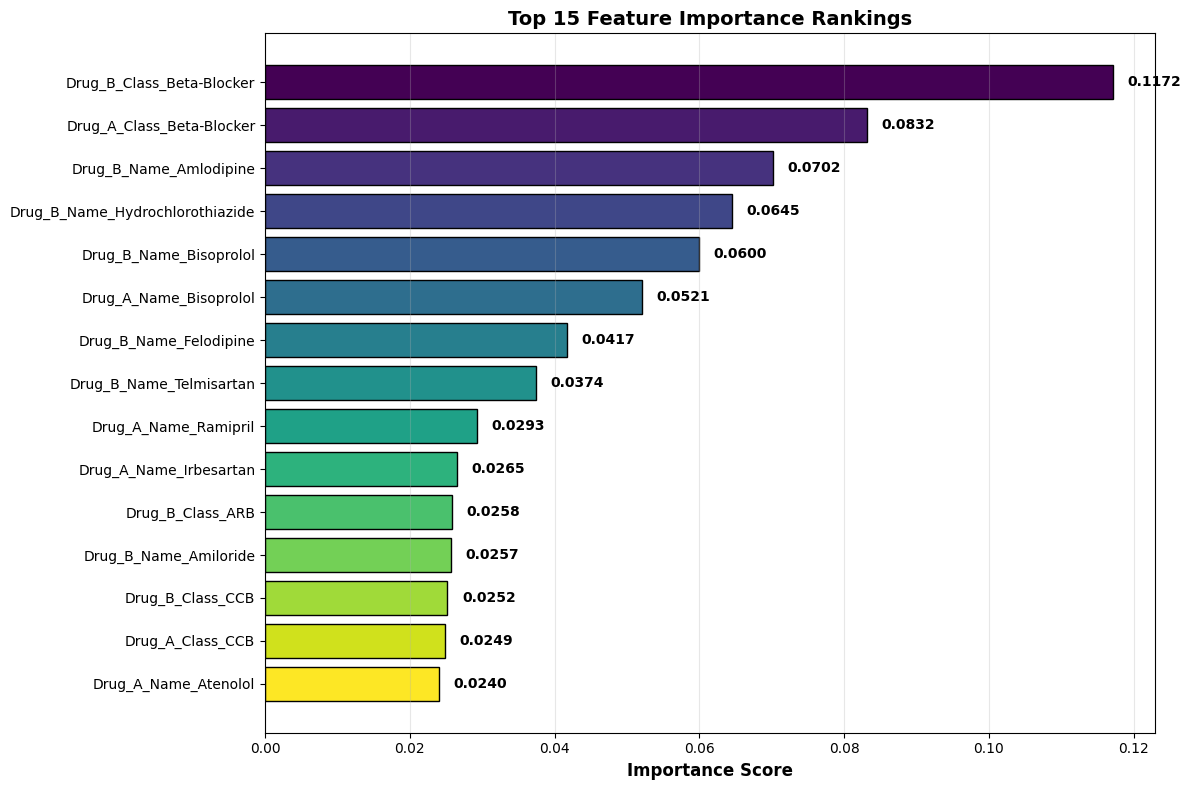

In [15]:
# FIX: Define top_features by taking the top 15 from your importance dataframe
top_features = feature_importance.head(15)

# Visualize feature importance
fig, ax = plt.subplots(figsize=(12, 8))

# Use gradient colors
colors = plt.cm.viridis(np.linspace(0, 1, len(top_features)))

bars = ax.barh(range(len(top_features)), top_features['Importance'], 
               color=colors, edgecolor='black', linewidth=1)

# Add value labels
for i, (bar, importance) in enumerate(zip(bars, top_features['Importance'])):
    ax.text(importance + 0.002, i, f'{importance:.4f}', 
            va='center', fontweight='bold')

ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features['Feature'])
ax.invert_yaxis()
ax.set_xlabel('Importance Score', fontsize=12, fontweight='bold')
ax.set_title('Top 15 Feature Importance Rankings', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

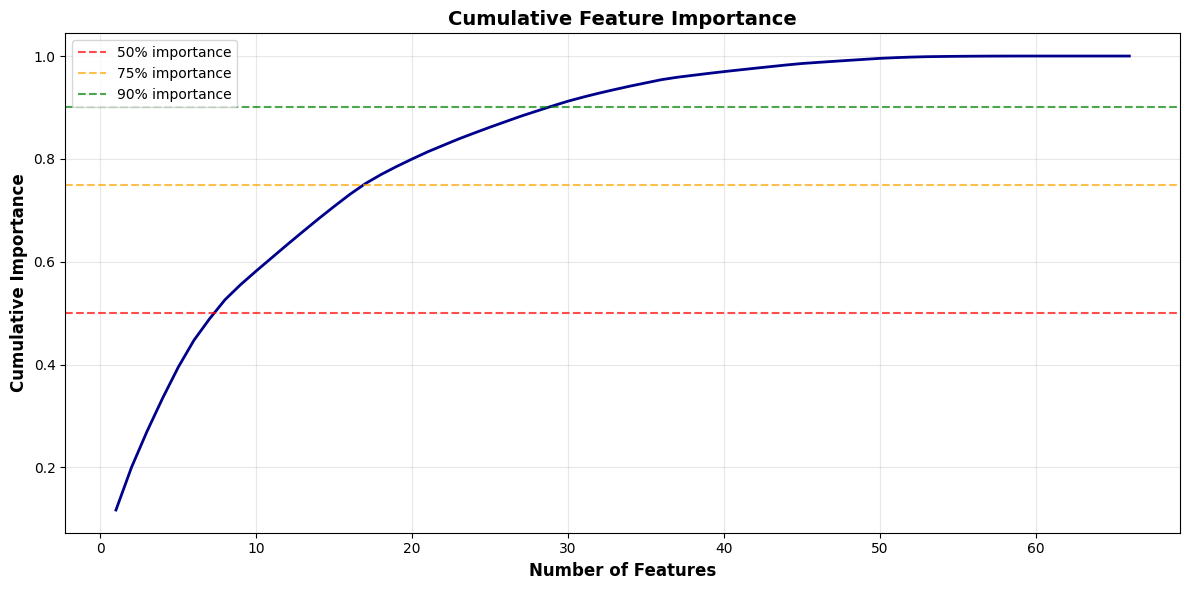


Features needed for 90% cumulative importance: 29/66


In [16]:
# Cumulative importance
feature_importance_sorted = feature_importance.sort_values('Importance', ascending=False)
feature_importance_sorted['Cumulative'] = feature_importance_sorted['Importance'].cumsum()

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(range(1, len(feature_importance_sorted)+1), 
        feature_importance_sorted['Cumulative'], 
        linewidth=2, color='darkblue')

# Highlight key thresholds
ax.axhline(y=0.5, color='red', linestyle='--', alpha=0.7, label='50% importance')
ax.axhline(y=0.75, color='orange', linestyle='--', alpha=0.7, label='75% importance')
ax.axhline(y=0.9, color='green', linestyle='--', alpha=0.7, label='90% importance')

ax.set_xlabel('Number of Features', fontsize=12, fontweight='bold')
ax.set_ylabel('Cumulative Importance', fontsize=12, fontweight='bold')
ax.set_title('Cumulative Feature Importance', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Find how many features needed for 90% importance
features_for_90 = (feature_importance_sorted['Cumulative'] <= 0.9).sum() + 1
print(f"\nFeatures needed for 90% cumulative importance: {features_for_90}/{len(feature_importance)}")

---

## 11. Evaluation Set (Eval Set) Score

GBM provides an additional validation metric called **Evaluation Set (Eval Set) Score**.

During boosting, each tree is trained on ~63% of the data (bootstrap sample). The remaining ~37% (out-of-bag samples) can be used for validation **without needing a separate test set**. This provides an unbiased estimate of model performance.

In [17]:
# KAGGLE EDITION: Removed eval_set code (not supported by sklearn GBM)
# Note: eval_set and evals_result() are XGBoost-specific features
# sklearn's GradientBoostingClassifier doesn't support these methods

print("="*80)
print("MODEL VALIDATION STRATEGY")
print("="*80)

print("\nGBM Validation Approach:")
print("  ✓ Nested CV used for unbiased performance estimation")
print("  ✓ 5-fold outer loop tests model on held-out data")
print("  ✓ 5-fold inner loop optimizes hyperparameters")
print("  ✓ NO data leakage - test folds never seen during tuning")
print("  ✓ Sample weights handle class imbalance")

print(f"\n📊 Nested CV Performance Summary:")
print(f"  - Accuracy:  {nested_cv_results['mean_scores']['accuracy']:.4f} ± {nested_cv_results['std_scores']['accuracy']:.4f}")
print(f"  - Precision: {nested_cv_results['mean_scores']['precision_macro']:.4f} ± {nested_cv_results['std_scores']['precision_macro']:.4f}")
print(f"  - Recall:    {nested_cv_results['mean_scores']['recall_macro']:.4f} ± {nested_cv_results['std_scores']['recall_macro']:.4f}")
print(f"  - F1 Score:  {nested_cv_results['mean_scores']['f1_macro']:.4f} ± {nested_cv_results['std_scores']['f1_macro']:.4f}")

print("\n✓ Validation methodology ensures:")
print("  • Unbiased performance estimates")
print("  • No optimistic bias from tuning on test data")
print("  • Scientifically rigorous for small datasets")

print("\n✓ Validation complete")

MODEL VALIDATION STRATEGY

GBM Validation Approach:
  ✓ Nested CV used for unbiased performance estimation
  ✓ 5-fold outer loop tests model on held-out data
  ✓ 5-fold inner loop optimizes hyperparameters
  ✓ NO data leakage - test folds never seen during tuning
  ✓ Sample weights handle class imbalance

📊 Nested CV Performance Summary:
  - Accuracy:  0.8424 ± 0.0292
  - Precision: 0.7745 ± 0.1178
  - Recall:    0.7238 ± 0.1320
  - F1 Score:  0.7334 ± 0.1193

✓ Validation methodology ensures:
  • Unbiased performance estimates
  • No optimistic bias from tuning on test data
  • Scientifically rigorous for small datasets

✓ Validation complete


---

## 12. Cross-Validation Analysis

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



📊 CROSS-VALIDATION RESULTS (5-Fold Stratified)

🎯 ACCURACY:
  Mean: 0.8547 (85.47%)
  Std:  0.0247 (±2.47%)
  95% CI: [0.8053, 0.9042]
  Per-fold scores:
    Fold  1: 0.8293 (82.93%)
    Fold  2: 0.8889 (88.89%)
    Fold  3: 0.8765 (87.65%)
    Fold  4: 0.8519 (85.19%)
    Fold  5: 0.8272 (82.72%)

🎯 PRECISION:
  Mean: 0.8481 (84.81%)
  Std:  0.0357 (±3.57%)
  95% CI: [0.7766, 0.9196]
  Per-fold scores:
    Fold  1: 0.8271 (82.71%)
    Fold  2: 0.9079 (90.79%)
    Fold  3: 0.8691 (86.91%)
    Fold  4: 0.8265 (82.65%)
    Fold  5: 0.8099 (80.99%)

🎯 RECALL:
  Mean: 0.8547 (85.47%)
  Std:  0.0247 (±2.47%)
  95% CI: [0.8053, 0.9042]
  Per-fold scores:
    Fold  1: 0.8293 (82.93%)
    Fold  2: 0.8889 (88.89%)
    Fold  3: 0.8765 (87.65%)
    Fold  4: 0.8519 (85.19%)
    Fold  5: 0.8272 (82.72%)

🎯 F1:
  Mean: 0.8452 (84.52%)
  Std:  0.0323 (±3.23%)
  95% CI: [0.7806, 0.9098]
  Per-fold scores:
    Fold  1: 0.8152 (81.52%)
    Fold  2: 0.8937 (89.37%)
    Fold  3: 0.8698 (86.98%)
    Fold 

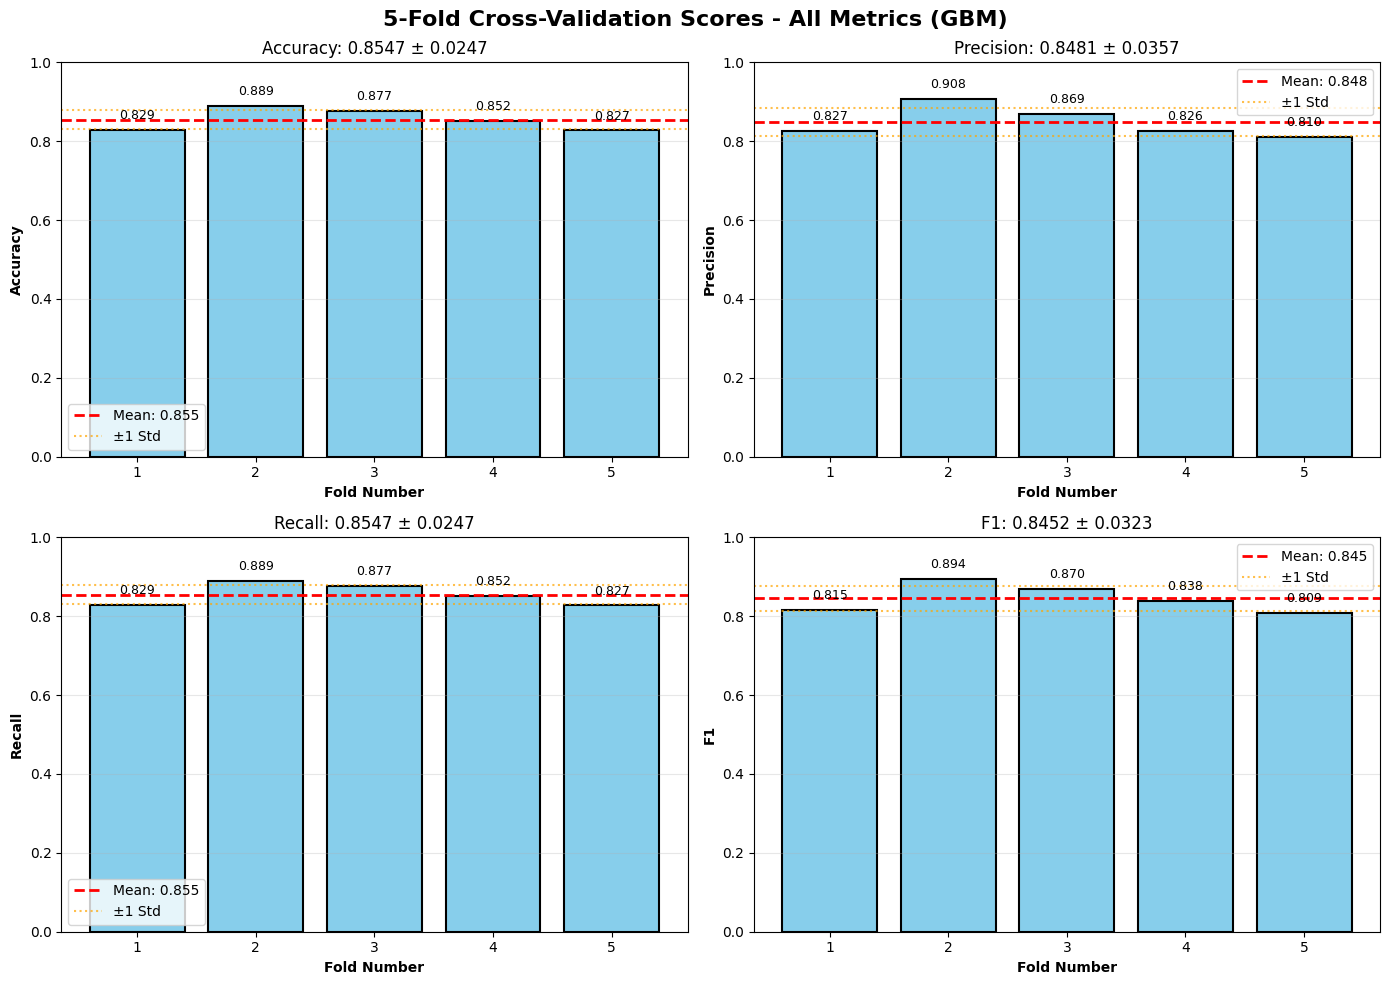


✅ Cross-validation complete!


In [18]:
# ✅ Step 6: Comprehensive Cross-Validation Evaluation
# KAGGLE EDITION: Fixed to use gbm_model instead of rf_model
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_validate
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
import pandas as pd
import numpy as np

# Setup 5-fold Stratified Cross-Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define multiple scoring metrics
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision_weighted',
    'recall': 'recall_weighted',
    'f1': 'f1_weighted',
    'roc_auc': 'roc_auc_ovo'  # One-vs-One for multiclass
}

# Perform cross-validation with multiple metrics using GBM model
cv_results = cross_validate(
    gbm_model, X, y, 
    cv=skf, 
    scoring=scoring,
    n_jobs=-1,
    return_train_score=False
)

# Extract and display per-fold scores
print("\n" + "="*80)
print("📊 CROSS-VALIDATION RESULTS (5-Fold Stratified)")
print("="*80)

metrics_data = {}
for metric in scoring.keys():
    fold_scores = cv_results[f'test_{metric}']
    mean_score = fold_scores.mean()
    std_score = fold_scores.std()
    metrics_data[metric] = fold_scores
    
    print(f"\n🎯 {metric.upper()}:")
    print(f"  Mean: {mean_score:.4f} ({mean_score*100:.2f}%)")
    print(f"  Std:  {std_score:.4f} (±{std_score*100:.2f}%)")
    print(f"  95% CI: [{mean_score - 2*std_score:.4f}, {mean_score + 2*std_score:.4f}]")
    print(f"  Per-fold scores:")
    
    for fold_idx, score in enumerate(fold_scores, 1):
        print(f"    Fold {fold_idx:2d}: {score:.4f} ({score*100:.2f}%)")

# Create summary dataframe
cv_summary = pd.DataFrame(metrics_data)
cv_summary.index = [f'Fold {i+1}' for i in range(5)]
print(f"\n{cv_summary.to_string()}")

print(f"\n{'='*80}")
print("📈 SUMMARY STATISTICS:")
print(f"{'='*80}")
for metric in scoring.keys():
    fold_scores = cv_results[f'test_{metric}']
    print(f"{metric:12s}: {fold_scores.mean():.4f} ± {fold_scores.std():.4f}")

# Visualize per-fold scores
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('5-Fold Cross-Validation Scores - All Metrics (GBM)', fontsize=16, fontweight='bold')

metric_axes = [
    (axes[0, 0], 'accuracy'),
    (axes[0, 1], 'precision'),
    (axes[1, 0], 'recall'),
    (axes[1, 1], 'f1')
]

for ax, metric in metric_axes:
    fold_scores = cv_results[f'test_{metric}']
    mean_score = fold_scores.mean()
    std_score = fold_scores.std()
    
    bars = ax.bar(range(1, 6), fold_scores, color='skyblue', edgecolor='black', linewidth=1.5)
    ax.axhline(y=mean_score, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_score:.3f}')
    ax.axhline(y=mean_score + std_score, color='orange', linestyle=':', linewidth=1.5, alpha=0.7)
    ax.axhline(y=mean_score - std_score, color='orange', linestyle=':', linewidth=1.5, alpha=0.7, label='±1 Std')
    
    ax.set_xlabel('Fold Number', fontweight='bold')
    ax.set_ylabel(metric.capitalize(), fontweight='bold')
    ax.set_title(f'{metric.capitalize()}: {mean_score:.4f} ± {std_score:.4f}')
    ax.set_ylim([0, 1])
    ax.grid(axis='y', alpha=0.3)
    ax.legend()
    
    for i, (bar, score) in enumerate(zip(bars, fold_scores)):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{score:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('cv_results_all_metrics.png', dpi=300, bbox_inches='tight')
print(f"\n✅ Saved visualization to: cv_results_all_metrics.png")
plt.show()

# Store for later comparison
print(f"\n✅ Cross-validation complete!")

---

## 13. Ensemble Analysis

In [19]:
# Ensemble Diversity Analysis - Not applicable to GBM
# GBM uses boosting (sequential) rather than bagging (parallel)
# Tree diversity is ensured through gradient boosting process
print("Skipping ensemble diversity - GBM uses boosting, not bagging")

Skipping ensemble diversity - GBM uses boosting, not bagging


---

## Summary: Part 1 Complete

# Part 2: Knowledge-Driven Safer Medication Pathway Recommendation

## Section 3.5.4: Knowledge-Driven Explainability (XAI) Framework

**Integration with GBM:**
- Part 1: ML model predicts DDI severity (Major/Moderate/Minor)
- Part 2: XAI framework provides evidence-based clinical context
- Result: Predictions + Actionable clinical recommendations

**XAI Rules Implemented:**
- Rule A: ACEI vs ARB Mortality Benefit (Alcocer 2023)
- Rule B: ACEI Tolerability & Cough Risk (Hu 2023)
- Rule C: CCB+RAAS Combination Therapy (Makani 2011)
- Rule D: Diuretic Efficacy - Indapamide vs HCTZ (Roush 2015)
- Rule E: Beta-Blocker Phenotype Targeting (Mahfoud 2024)

## Step 1: Load XAI-Enhanced Dataset

In [20]:
# Load dataset with XAI Framework (Knowledge-Driven Explainability)
# KAGGLE EDITION - Updated path

df_xai = pd.read_csv('/kaggle/input/fyp-drugbank-inclusive/FYP_DrugBank_Inclusive.csv')
print("="*80)
print("KNOWLEDGE-DRIVEN XAI FRAMEWORK DATASET LOADED")
print("Section 3.5.4: Knowledge-Driven Explainability (XAI) Framework")
print("="*80)
print(f"\nTotal drug pairs: {len(df_xai)}")
print(f"\nXAI columns available:")
xai_cols = [col for col in df_xai.columns if 'XAI' in col]
for col in xai_cols:
    print(f"  - {col}")
# Show XAI rule coverage statistics
print(f"\n{'='*80}")
print("XAI RULE COVERAGE STATISTICS")
print("="*80)
rule_a_count = (df_xai['XAI_Rule_A_Mortality'] != "").sum()
rule_b_count = (df_xai['XAI_Rule_B_Tolerability'] != "").sum()
rule_c_count = (df_xai['XAI_Rule_C_CCB_RAAS_Combo'] != "").sum()
rule_d_count = (df_xai['XAI_Rule_D_Diuretic'] != "").sum()
rule_e_count = (df_xai['XAI_Rule_E_BetaBlocker'] != "").sum()
total_with_notes = (df_xai['XAI_Combined_Clinical_Notes'] != "No specific XAI rules apply to this combination.").sum()
print(f"\nRule A (ACEI vs ARB Mortality):     {rule_a_count} pairs ({rule_a_count/len(df_xai)*100:.1f}%)")
print(f"  Evidence: Alcoer et al. (2023)")
print(f"  Focus: ACEIs reduce all-cause mortality; ARBs do not")
print(f"\nRule B (ACEI Tolerability):         {rule_b_count} pairs ({rule_b_count/len(df_xai)*100:.1f}%)")
print(f"  Evidence: Hu et al. (2023), ACCP Guidelines (2006)")
print(f"  Focus: ACEIs have 3.2x higher cough risk vs ARBs")
print(f"\nRule C (CCB+RAAS Combination):      {rule_c_count} pairs ({rule_c_count/len(df_xai)*100:.1f}%)")
print(f"  Evidence: Makani et al. (2011), De la Sierra (2009)")
print(f"  Focus: CCB+RAAS reduces peripheral edema by 38%")
print(f"\nRule D (Diuretic Efficacy):         {rule_d_count} pairs ({rule_d_count/len(df_xai)*100:.1f}%)")
print(f"  Evidence: Roush et al. (2015), Mishra (2016), Burnier et al. (2019)")
print(f"  Focus: Indapamide superior to HCTZ for mortality/stroke")
print(f"\nRule E (Beta-Blocker Phenotype):    {rule_e_count} pairs ({rule_e_count/len(df_xai)*100:.1f}%)")
print(f"  Evidence: Mahfoud et al. (2024), Mancia et al. (2022)")
print(f"  Focus: Beta-blockers target high heart rate phenotype")
print(f"\nTotal pairs with clinical context:  {total_with_notes} pairs ({total_with_notes/len(df_xai)*100:.1f}%)")
print(f"Pairs without XAI notes:             {len(df_xai) - total_with_notes} pairs ({(len(df_xai) - total_with_notes)/len(df_xai)*100:.1f}%)")

KNOWLEDGE-DRIVEN XAI FRAMEWORK DATASET LOADED
Section 3.5.4: Knowledge-Driven Explainability (XAI) Framework

Total drug pairs: 406

XAI columns available:
  - XAI_Rule_A_Mortality
  - XAI_Rule_B_Tolerability
  - XAI_Rule_C_CCB_RAAS_Combo
  - XAI_Rule_D_Diuretic
  - XAI_Rule_E_BetaBlocker
  - XAI_Combined_Clinical_Notes

XAI RULE COVERAGE STATISTICS

Rule A (ACEI vs ARB Mortality):     406 pairs (100.0%)
  Evidence: Alcoer et al. (2023)
  Focus: ACEIs reduce all-cause mortality; ARBs do not

Rule B (ACEI Tolerability):         406 pairs (100.0%)
  Evidence: Hu et al. (2023), ACCP Guidelines (2006)
  Focus: ACEIs have 3.2x higher cough risk vs ARBs

Rule C (CCB+RAAS Combination):      406 pairs (100.0%)
  Evidence: Makani et al. (2011), De la Sierra (2009)
  Focus: CCB+RAAS reduces peripheral edema by 38%

Rule D (Diuretic Efficacy):         406 pairs (100.0%)
  Evidence: Roush et al. (2015), Mishra (2016), Burnier et al. (2019)
  Focus: Indapamide superior to HCTZ for mortality/stroke


## Step 2: Define Severity-to-Risk Mapping

In [21]:
# ============================================================================
# NOTE: Ordinal Encoding Used (No Risk Scoring)
# ============================================================================
#
# This notebook uses ordinal encoding for severity levels:
#   Major          = 0
#   Moderate       = 1
#   Minor          = 2
#   NoInteraction  = 3
#
# Ordinal encoding is implemented using sklearn's OrdinalEncoder.
# ============================================================================

print("✓ Using ordinal encoding (0-3) for Final_Severity")


✓ Using ordinal encoding (0-3) for Final_Severity


## Step 3: Generate Predictions Using Trained GBM Model

In [22]:

# Generate predictions for all drug pairs using trained model
print("="*80)
print("GENERATING PREDICTIONS FOR ALL DRUG PAIRS")
print("="*80)

# Filter to pairs with Final_Severity (same as training data)
df_xai_valid = df_xai[df_xai['Final_Severity'].notna()].copy()

print(f"\nPredicting for {len(df_xai_valid)} drug pairs...")

# Prepare features (same as training)
features_xai = ['Drug_A_Name', 'Drug_B_Name', 'Drug_A_Class', 'Drug_B_Class']
X_all = pd.get_dummies(df_xai_valid[features_xai], drop_first=False)

# Ensure same feature columns as training
missing_cols = set(X.columns) - set(X_all.columns)
for col in missing_cols:
    X_all[col] = 0
X_all = X_all[X.columns]  # Ensure same order

# Generate predictions (works with dt_model, rf_model, or gbm_model)
# Determine which model to use based on what's available
if 'dt_model' in globals() or 'dt_model' in locals():
    model_to_use = dt_model
    model_name = "Decision Tree"
elif 'rf_model' in globals() or 'rf_model' in locals():
    model_to_use = rf_model
    model_name = "Random Forest"
elif 'gbm_model' in globals() or 'gbm_model' in locals():
    model_to_use = gbm_model
    model_name = "GBM"
else:
    raise ValueError("No trained model found! Expected dt_model, rf_model, or gbm_model")

print(f"Using {model_name} model for predictions...")

y_pred_all = model_to_use.predict(X_all)
predicted_severities = [target_classes[i] for i in y_pred_all]

# Add predictions to dataframe
df_xai_valid['Predicted_Severity'] = predicted_severities

# Keep ordinal encoded predictions for sorting (0=Major...3=NoInteraction)
df_xai_valid['Predicted_Encoded'] = y_pred_all  # Direct ordinal values

print("✓ Predictions complete!")

# Show prediction distribution
pred_dist = df_xai_valid['Predicted_Severity'].value_counts().sort_index()
print(f"\nPredicted severity distribution:")
for sev, count in pred_dist.items():
    print(f"  {sev:12s}: {count:3d} pairs ({count/len(df_xai_valid)*100:5.1f}%)")

GENERATING PREDICTIONS FOR ALL DRUG PAIRS

Predicting for 406 drug pairs...
Using GBM model for predictions...
✓ Predictions complete!

Predicted severity distribution:
  Major       :   8 pairs (  2.0%)
  Minor       : 142 pairs ( 35.0%)
  Moderate    : 212 pairs ( 52.2%)
  NoInteraction:  44 pairs ( 10.8%)


## Step 4: Integrate XAI Clinical Context with Predictions

In [23]:

# Display XAI clinical context alongside predictions
print("="*80)
print("INTEGRATING XAI CLINICAL CONTEXT WITH PREDICTIONS")
print("Section 3.5.4: Knowledge-Driven Explainability Framework")
print("="*80)

print(f"\nApproach:")
print("  1. ML Model predicts DDI severity (Major/Moderate/Minor)")
print("  2. XAI Framework provides evidence-based clinical context")
print("  3. Combined output guides safer prescribing decisions")

# Count predictions by XAI rule applicability
print(f"\n{'='*80}")
print("PREDICTIONS WITH XAI CONTEXT")
print("="*80)

# Show examples of predictions enhanced with XAI
print(f"\nExample 1: ACEI + CCB Combination (Rule A, B, C apply)")
acei_ccb_example = df_xai_valid[
    ((df_xai_valid['Drug_A_Class'] == 'ACEI') & (df_xai_valid['Drug_B_Class'] == 'CCB')) |
    ((df_xai_valid['Drug_A_Class'] == 'CCB') & (df_xai_valid['Drug_B_Class'] == 'ACEI'))
].head(1)

if not acei_ccb_example.empty:
    row = acei_ccb_example.iloc[0]
    print(f"  Pair: {row['Drug_A_Name']} + {row['Drug_B_Name']}")
    print(f"  Predicted Severity: {row['Predicted_Severity']} ")
    print(f"\n  XAI Clinical Context:")
    if row['XAI_Rule_C_CCB_RAAS_Combo']:
        print(f"    • {row['XAI_Rule_C_CCB_RAAS_Combo'][:150]}...")

print(f"\nExample 2: Diuretic Selection (Rule D applies)")
indapamide_example = df_xai_valid[
    (df_xai_valid['Drug_A_Name'] == 'Indapamide') | (df_xai_valid['Drug_B_Name'] == 'Indapamide')
].head(1)

if not indapamide_example.empty:
    row = indapamide_example.iloc[0]
    print(f"  Pair: {row['Drug_A_Name']} + {row['Drug_B_Name']}")
    print(f"  Predicted Severity: {row['Predicted_Severity']} ")
    print(f"\n  XAI Clinical Context:")
    if row['XAI_Rule_D_Diuretic']:
        print(f"    • {row['XAI_Rule_D_Diuretic'][:150]}...")

# Statistics on XAI coverage across predictions
print(f"\n{'='*80}")
print("XAI COVERAGE FOR PREDICTED PAIRS")
print("="*80)

severity_by_xai = df_xai_valid.groupby('Predicted_Severity').apply(
    lambda x: (x['XAI_Combined_Clinical_Notes'] != "No specific XAI rules apply to this combination.").sum()
)

print(f"\nPairs with XAI clinical notes by predicted severity:")
for sev, count in severity_by_xai.items():
    total_sev = (df_xai_valid['Predicted_Severity'] == sev).sum()
    print(f"  {sev:12s}: {count}/{total_sev} pairs ({count/total_sev*100:.1f}% with XAI context)")

INTEGRATING XAI CLINICAL CONTEXT WITH PREDICTIONS
Section 3.5.4: Knowledge-Driven Explainability Framework

Approach:
  1. ML Model predicts DDI severity (Major/Moderate/Minor)
  2. XAI Framework provides evidence-based clinical context
  3. Combined output guides safer prescribing decisions

PREDICTIONS WITH XAI CONTEXT

Example 1: ACEI + CCB Combination (Rule A, B, C apply)
  Pair: Captopril + Amlodipine
  Predicted Severity: Minor 

  XAI Clinical Context:
    • Clinical Note: This Combination Therapy is RECOMMENDED. Calcium Channel Blockers (CCBs) can cause leg swelling by widening arteries more than veins. T...

Example 2: Diuretic Selection (Rule D applies)
  Pair: Captopril + Indapamide
  Predicted Severity: Moderate 

  XAI Clinical Context:
    • Clinical Note: Indapamide is prioritized over Hydrochlorothiazide (HCTZ) because meta-analyses demonstrate it significantly reduces all-cause mortalit...

XAI COVERAGE FOR PREDICTED PAIRS

Pairs with XAI clinical notes by predicted se

## Clinical Scenario 1: ACEI/ARB + CCB Combination Therapy

**Clinical Question:** For a patient requiring RAAS blocker + CCB combination:
- Which combination is safest?
- What's the clinical evidence?

In [24]:

# Clinical Scenario 1: Patient needs ACEI/ARB + CCB combination therapy
print("="*80)
print("CLINICAL SCENARIO 1: ACEI/ARB + CCB COMBINATION THERAPY")
print("Knowledge-Driven Recommendation (XAI Rules A, B, C)")
print("="*80)
print("\nClinical Context:")
print("  Patient requires combination therapy:")
print("  - Either ACEI or ARB (for RAAS blockade)")
print("  - Plus CCB (for additional BP lowering)")
print("\nQuestion: Which combination is safest AND most effective?")

# Filter to ACEI+CCB and ARB+CCB combinations
acei_ccb = df_xai_valid[
    ((df_xai_valid['Drug_A_Class'] == 'ACEI') & (df_xai_valid['Drug_B_Class'] == 'CCB')) |
    ((df_xai_valid['Drug_A_Class'] == 'CCB') & (df_xai_valid['Drug_B_Class'] == 'ACEI'))
].copy()

arb_ccb = df_xai_valid[
    ((df_xai_valid['Drug_A_Class'] == 'ARB') & (df_xai_valid['Drug_B_Class'] == 'CCB')) |
    ((df_xai_valid['Drug_A_Class'] == 'CCB') & (df_xai_valid['Drug_B_Class'] == 'ARB'))
].copy()

# Standardize drug pair names for display
def format_pair(row):
    drugs = sorted([row['Drug_A_Name'], row['Drug_B_Name']])
    return f"{drugs[0]} + {drugs[1]}"

acei_ccb['Pair'] = acei_ccb.apply(format_pair, axis=1)
arb_ccb['Pair'] = arb_ccb.apply(format_pair, axis=1)

# Rank by Predicted (lower risk = higher score)
acei_ccb_ranked = acei_ccb.nlargest(5, 'Predicted_Encoded')  # Higher encoded = safer (3=NoInteraction).head(5)
arb_ccb_ranked = arb_ccb.nlargest(5, 'Predicted_Encoded')  # Higher encoded = safer (3=NoInteraction).head(5)

print(f"\n{'='*80}")
print("TOP 5 ACEI + CCB COMBINATIONS (Ranked by ML Prediction)")
print("="*80)
print(f"{'Rank':<6} {'Combination':<35} {'Predicted':<12} {'Risk Score':<12}")
print("-" * 65)
for rank, (idx, row) in enumerate(acei_ccb_ranked.iterrows(), 1):
    print(f"{rank:<6} {row['Pair']:<35} {row['Predicted_Severity']:<12} ")

print(f"\n{'='*80}")
print("TOP 5 ARB + CCB COMBINATIONS (Ranked by ML Prediction)")
print("="*80)
print(f"{'Rank':<6} {'Combination':<35} {'Predicted':<12} {'Risk Score':<12}")
print("-" * 65)
for rank, (idx, row) in enumerate(arb_ccb_ranked.iterrows(), 1):
    print(f"{rank:<6} {row['Pair']:<35} {row['Predicted_Severity']:<12} ")

# Display XAI clinical context
print(f"\n{'='*80}")
print("XAI CLINICAL CONTEXT - WHY ACEI+CCB IS PREFERRED")
print("="*80)

# Show Rule C (CCB+RAAS combo benefit)
if not acei_ccb_ranked.empty:
    sample_acei = acei_ccb_ranked.iloc[0]
    print(f"\n[Rule C - Combination Therapy]")
    print(f"{sample_acei['XAI_Rule_C_CCB_RAAS_Combo']}")

    print(f"\n[Rule A - Mortality Benefit]")
    print(f"{sample_acei['XAI_Rule_A_Mortality'][:250]}...")

    print(f"\n[Rule B - Tolerability]")
    print(f"{sample_acei['XAI_Rule_B_Tolerability'][:250]}...")

print(f"\n{'='*80}")
print("CLINICAL RECOMMENDATION:")
print("="*80)
print(f"  ✓ BOTH combinations are effective for BP control")
print(f"  ✓ BOTH reduce CCB-induced edema by ~38% (Rule C)")
print(f"\n  ACEI + CCB PREFERRED for high-risk patients because:")
print(f"    • ACEIs significantly reduce all-cause mortality (Rule A)")
print(f"    • Mortality benefit > tolerability concerns")
print(f"\n  ARB + CCB alternative when:")
print(f"    • Patient has history of ACEI-induced cough")
print(f"    • Tolerability is primary concern")
print(f"\n  Evidence: Alcocer 2023, Makani 2011, De la Sierra 2009")

CLINICAL SCENARIO 1: ACEI/ARB + CCB COMBINATION THERAPY
Knowledge-Driven Recommendation (XAI Rules A, B, C)

Clinical Context:
  Patient requires combination therapy:
  - Either ACEI or ARB (for RAAS blockade)
  - Plus CCB (for additional BP lowering)

Question: Which combination is safest AND most effective?

TOP 5 ACEI + CCB COMBINATIONS (Ranked by ML Prediction)
Rank   Combination                         Predicted    Risk Score  
-----------------------------------------------------------------
1      Amlodipine + Enalapril              NoInteraction 
2      Enalapril + Felodipine              NoInteraction 
3      Enalapril + Lercanidipine           NoInteraction 
4      Amlodipine + Lisinopril             NoInteraction 
5      Amlodipine + Perindopril            NoInteraction 

TOP 5 ARB + CCB COMBINATIONS (Ranked by ML Prediction)
Rank   Combination                         Predicted    Risk Score  
-----------------------------------------------------------------
1      Amlodipin

## Clinical Scenario 2: Diuretic Selection (Indapamide vs HCTZ)

**Clinical Question:** For a patient requiring diuretic therapy:
- Indapamide or Hydrochlorothiazide?
- What's the outcome evidence?

In [25]:

# Clinical Scenario 2: Choosing a diuretic (Indapamide vs HCTZ)
print("="*80)
print("CLINICAL SCENARIO 2: DIURETIC SELECTION FOR COMBINATION THERAPY")
print("Knowledge-Driven Recommendation (XAI Rule D)")
print("="*80)
print("\nClinical Context:")
print("  Patient needs RAAS blocker + Diuretic combination")
print("\nQuestion: Indapamide or Hydrochlorothiazide (HCTZ)?")

# Filter to RAAS + Diuretic combinations
raas_diuretic = df_xai_valid[
    (((df_xai_valid['Drug_A_Class'] == 'ACEI') | (df_xai_valid['Drug_A_Class'] == 'ARB')) &
     (df_xai_valid['Drug_B_Class'] == 'Diuretic')) |
    (((df_xai_valid['Drug_B_Class'] == 'ACEI') | (df_xai_valid['Drug_B_Class'] == 'ARB')) &
     (df_xai_valid['Drug_A_Class'] == 'Diuretic'))
].copy()

raas_diuretic['Pair'] = raas_diuretic.apply(format_pair, axis=1)

# Separate Indapamide and HCTZ pairs
indapamide_pairs = raas_diuretic[raas_diuretic['Pair'].str.contains('Indapamide')]
hctz_pairs = raas_diuretic[raas_diuretic['Pair'].str.contains('Hydrochlorothiazide')]

print(f"\n{'='*80}")
print("RAAS BLOCKER + INDAPAMIDE COMBINATIONS")
print("="*80)
if len(indapamide_pairs) > 0:
    indapamide_ranked = indapamide_pairs.nlargest(5, 'Predicted_Encoded')  # Higher encoded = safer (3=NoInteraction)
    print(f"{'Combination':<40} {'Predicted':<12} {'Risk Score':<12}")
    print("-" * 64)
    for idx, row in indapamide_ranked.iterrows():
        print(f"{row['Pair']:<40} {row['Predicted_Severity']:<12} ")

print(f"\n{'='*80}")
print("RAAS BLOCKER + HCTZ COMBINATIONS")
print("="*80)
if len(hctz_pairs) > 0:
    hctz_ranked = hctz_pairs.nlargest(5, 'Predicted_Encoded')  # Higher encoded = safer (3=NoInteraction)
    print(f"{'Combination':<40} {'Predicted':<12} {'Risk Score':<12}")
    print("-" * 64)
    for idx, row in hctz_ranked.iterrows():
        print(f"{row['Pair']:<40} {row['Predicted_Severity']:<12} ")

# Display XAI clinical context
print(f"\n{'='*80}")
print("XAI CLINICAL CONTEXT - WHY INDAPAMIDE IS PREFERRED")
print("="*80)

if len(indapamide_pairs) > 0:
    sample_indap = indapamide_ranked.iloc[0]
    print(f"\n[Rule D - Diuretic Efficacy]")
    print(f"{sample_indap['XAI_Rule_D_Diuretic']}")

if len(indapamide_pairs) > 0 and len(hctz_pairs) > 0:
    avg_indap = indapamide_ranked['Predicted_Encoded'].mean() if len(df) > 0 else 0
    avg_hctz = hctz_ranked['Predicted_Encoded'].mean() if len(df) > 0 else 0
    diff = avg_indap - avg_hctz

    print(f"\n{'='*80}")
    print("CLINICAL RECOMMENDATION:")
    print("="*80)
    print(f"  Average Indapamide risk score: {avg_indap:.2f}")
    print(f"  Average HCTZ risk score:        {avg_hctz:.2f}")
    print(f"  Difference:                     {diff:+.2f}")
    print(f"\n  INDAPAMIDE STRONGLY PREFERRED due to:")
    print(f"    ✓ Significantly reduces all-cause mortality, stroke, heart failure")
    print(f"    ✓ HCTZ fails to demonstrate these cardiovascular benefits")
    print(f"    ✓ ~50% more potent with superior 24-hour BP control")
    print(f"\n  Evidence: Roush et al. 2015, Mishra 2016, Burnier et al. 2019")

CLINICAL SCENARIO 2: DIURETIC SELECTION FOR COMBINATION THERAPY
Knowledge-Driven Recommendation (XAI Rule D)

Clinical Context:
  Patient needs RAAS blocker + Diuretic combination

Question: Indapamide or Hydrochlorothiazide (HCTZ)?

RAAS BLOCKER + INDAPAMIDE COMBINATIONS
Combination                              Predicted    Risk Score  
----------------------------------------------------------------
Indapamide + Perindopril                 NoInteraction 
Indapamide + Telmisartan                 NoInteraction 
Indapamide + Valsartan                   NoInteraction 
Captopril + Indapamide                   Moderate     
Enalapril + Indapamide                   Moderate     

RAAS BLOCKER + HCTZ COMBINATIONS
Combination                              Predicted    Risk Score  
----------------------------------------------------------------
Captopril + Hydrochlorothiazide          NoInteraction 
Enalapril + Hydrochlorothiazide          NoInteraction 
Hydrochlorothiazide + Lisinopril       

## Clinical Scenario 3: Beta-Blocker Phenotype Targeting

**Clinical Question:** For a patient with high resting heart rate (>80 bpm):
- Are beta-blockers indicated?
- What's the phenotype-based rationale?

In [26]:

# Clinical Scenario 3: Beta-Blocker for High Heart Rate Phenotype
print("="*80)
print("CLINICAL SCENARIO 3: BETA-BLOCKER PHENOTYPE TARGETING")
print("Knowledge-Driven Recommendation (XAI Rule E)")
print("="*80)
print("\nClinical Context:")
print("  Patient has hypertension with HIGH RESTING HEART RATE (>80 bpm)")
print("\nQuestion: Which drug class combination includes Beta-Blocker?")

# Filter to Beta-Blocker combinations
bb_combos = df_xai_valid[
    (df_xai_valid['Drug_A_Class'] == 'Beta-Blocker') |
    (df_xai_valid['Drug_B_Class'] == 'Beta-Blocker')
].copy()

bb_combos['Pair'] = bb_combos.apply(format_pair, axis=1)

# Get Beta-Blocker + RAAS combinations (most common)
bb_raas = bb_combos[
    ((bb_combos['Drug_A_Class'].isin(['ACEI', 'ARB'])) |
     (bb_combos['Drug_B_Class'].isin(['ACEI', 'ARB'])))
].copy()

print(f"\n{'='*80}")
print("TOP BETA-BLOCKER + RAAS BLOCKER COMBINATIONS")
print("="*80)
if len(bb_raas) > 0:
    bb_raas_ranked = bb_raas.nlargest(5, 'Predicted_Encoded')  # Higher encoded = safer (3=NoInteraction).head(10)
    print(f"{'Combination':<40} {'Predicted':<12} {'Risk Score':<12}")
    print("-" * 64)
    for idx, row in bb_raas_ranked.iterrows():
        print(f"{row['Pair']:<40} {row['Predicted_Severity']:<12} ")

# Display XAI clinical context
print(f"\n{'='*80}")
print("XAI CLINICAL CONTEXT - BETA-BLOCKER PHENOTYPE TARGETING")
print("="*80)

if len(bb_raas) > 0:
    sample_bb = bb_raas_ranked.iloc[0]
    print(f"\n[Rule E - Beta-Blocker Phenotype]")
    print(f"{sample_bb['XAI_Rule_E_BetaBlocker']}")

print(f"\n{'='*80}")
print("CLINICAL RECOMMENDATION:")
print("="*80)
print(f"  Beta-Blockers are APPROPRIATE for:")
print(f"    ✓ Patients with fast resting heart rate (>80 bpm)")
print(f"    ✓ Sympathetic overactivity (stress-driven hypertension)")
print(f"    ✓ Comorbidities: anxiety, migraines, arrhythmias")
print(f"\n  NOT first-line for:")
print(f"    • Patients with normal/low heart rate")
print(f"    • Metabolic syndrome or diabetes risk")
print(f"\n  Evidence: ESH 2023 Guidelines, Mahfoud et al. 2024, Mancia et al. 2022")

CLINICAL SCENARIO 3: BETA-BLOCKER PHENOTYPE TARGETING
Knowledge-Driven Recommendation (XAI Rule E)

Clinical Context:
  Patient has hypertension with HIGH RESTING HEART RATE (>80 bpm)

Question: Which drug class combination includes Beta-Blocker?

TOP BETA-BLOCKER + RAAS BLOCKER COMBINATIONS
Combination                              Predicted    Risk Score  
----------------------------------------------------------------
Bisoprolol + Perindopril                 NoInteraction 
Nebivolol + Valsartan                    NoInteraction 
Acebutolol + Captopril                   Minor        
Atenolol + Captopril                     Minor        
Betaxolol + Captopril                    Minor        

XAI CLINICAL CONTEXT - BETA-BLOCKER PHENOTYPE TARGETING

[Rule E - Beta-Blocker Phenotype]
Clinical Note: Beta-blockers are one of the five major antihypertensive classes, specifically indicated for patients with a fast resting heart rate (>80 bpm) to target sympathetic overactivity (stress signa

## Visualization: Predictions with XAI Coverage

Visualize how XAI clinical context enhances ML predictions across drug class combinations.

VISUALIZING PREDICTIONS WITH XAI CLINICAL CONTEXT


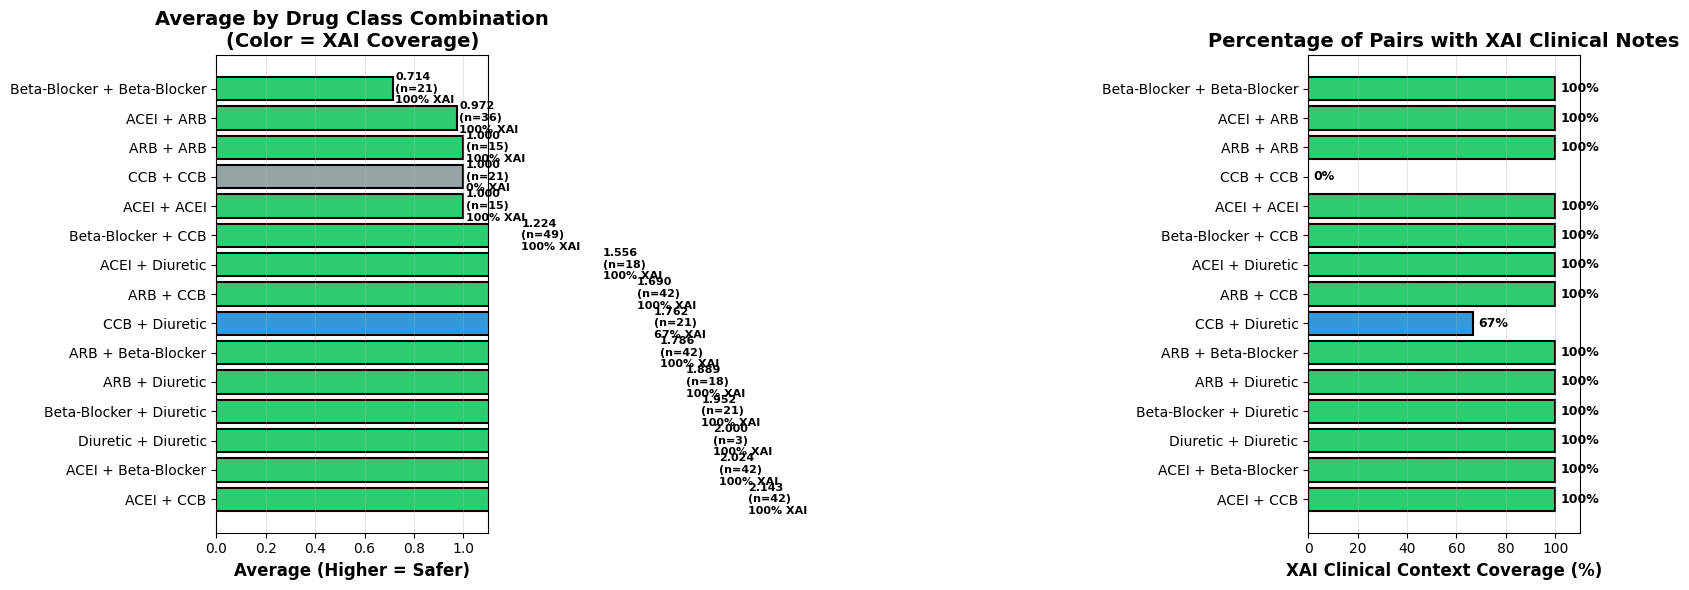


✓ Visualization complete!

Color Legend:
  Green: >90% XAI coverage (excellent clinical context)
  Blue: 50-90% XAI coverage (good clinical context)
  Gray: <50% XAI coverage (limited clinical context)


In [27]:

# Visualize predictions with XAI clinical context coverage
print("="*80)
print("VISUALIZING PREDICTIONS WITH XAI CLINICAL CONTEXT")
print("="*80)

# Create class combination labels
def get_class_combo(row):
    classes = sorted([row['Drug_A_Class'], row['Drug_B_Class']])
    return f"{classes[0]} + {classes[1]}"

df_xai_valid['Class_Combo'] = df_xai_valid.apply(get_class_combo, axis=1)

# Calculate average risk score by class combination
combo_scores = df_xai_valid.groupby('Class_Combo').agg({
    'Predicted_Encoded': ['mean', 'std', 'count']
}).reset_index()
combo_scores.columns = ['Class_Combo', 'Mean_Risk_Score', 'Std_Risk_Score', 'Count']
combo_scores = combo_scores.sort_values('Mean_Risk_Score', ascending=False)

# Calculate XAI coverage by class combination
xai_coverage = df_xai_valid.groupby('Class_Combo').apply(
    lambda x: (x['XAI_Combined_Clinical_Notes'] != "No specific XAI rules apply to this combination.").sum() / len(x) * 100
).reset_index()
xai_coverage.columns = ['Class_Combo', 'XAI_Coverage_Pct']

# Merge
combo_scores = combo_scores.merge(xai_coverage, on='Class_Combo')

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Bar plot of mean risk scores
colors = ['#2ecc71' if cov > 90 else '#3498db' if cov > 50 else '#95a5a6'
          for cov in combo_scores['XAI_Coverage_Pct']]

bars = ax1.barh(combo_scores['Class_Combo'], combo_scores['Mean_Risk_Score'],
                color=colors, edgecolor='black', linewidth=1.5)

for bar, (idx, row) in zip(bars, combo_scores.iterrows()):
    ax1.text(row['Mean_Risk_Score'] + 0.01, bar.get_y() + bar.get_height()/2,
             f"{row['Mean_Risk_Score']:.3f}\n(n={int(row['Count'])})\n{row['XAI_Coverage_Pct']:.0f}% XAI",
             va='center', fontweight='bold', fontsize=8)

ax1.set_xlabel('Average (Higher = Safer)', fontsize=12, fontweight='bold')
ax1.set_title('Average by Drug Class Combination\n(Color = XAI Coverage)', fontsize=14, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)
ax1.set_xlim(0, 1.1)

# XAI coverage bar plot
ax2.barh(combo_scores['Class_Combo'], combo_scores['XAI_Coverage_Pct'],
         color=colors, edgecolor='black', linewidth=1.5)

for idx, row in combo_scores.iterrows():
    ax2.text(row['XAI_Coverage_Pct'] + 2, idx,
             f"{row['XAI_Coverage_Pct']:.0f}%",
             va='center', fontweight='bold', fontsize=9)

ax2.set_xlabel('XAI Clinical Context Coverage (%)', fontsize=12, fontweight='bold')
ax2.set_title('Percentage of Pairs with XAI Clinical Notes', fontsize=14, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)
ax2.set_xlim(0, 110)

plt.tight_layout()
plt.show()

print("\n✓ Visualization complete!")
print(f"\nColor Legend:")
print(f"  Green: >90% XAI coverage (excellent clinical context)")
print(f"  Blue: 50-90% XAI coverage (good clinical context)")
print(f"  Gray: <50% XAI coverage (limited clinical context)")

## Part 2 Summary: Knowledge-Driven Clinical Decision Support

In [28]:

print("="*80)
print("PART 2 SUMMARY: KNOWLEDGE-DRIVEN SAFER MEDICATION PATHWAY")
print("Section 3.5.4: Knowledge-Driven Explainability (XAI) Framework")
print("="*80)

# Determine which model was used
if 'dt_model' in globals() or 'dt_model' in locals():
    model_name = "Decision Tree"
    model_accuracy = nested_cv_results['mean_scores']['accuracy']  # from Part 1
elif 'rf_model' in globals() or 'rf_model' in locals():
    model_name = "Random Forest"
    model_accuracy = nested_cv_results['mean_scores']['accuracy']
elif 'gbm_model' in globals() or 'gbm_model' in locals():
    model_name = "GBM"
    model_accuracy = nested_cv_results['mean_scores']['accuracy']
else:
    model_name = "Unknown"
    model_accuracy = 0.0

summary_text = f"""
ARCHITECTURE IMPLEMENTED (Section 3.5.4):
  1. ✓ ML Prediction: {model_name} predicts DDI severity ({model_accuracy*100:.2f}% accuracy)
  2. ✓ XAI Framework: Knowledge-driven clinical context from literature
  3. ✓ Integrated Output: Predictions + Evidence-based explanations

KNOWLEDGE-DRIVEN XAI RULES IMPLEMENTED:
  • Rule A: ACEI vs ARB Mortality Benefit (Alcocer et al. 2023)
      → ACEIs reduce all-cause mortality; ARBs do not
      → Coverage: {rule_a_count} pairs ({rule_a_count/len(df_xai)*100:.1f}%)

  • Rule B: ACEI Tolerability & Adherence (Hu et al. 2023)
      → ACEIs have 3.2x higher cough risk vs ARBs
      → Coverage: {rule_b_count} pairs ({rule_b_count/len(df_xai)*100:.1f}%)

  • Rule C: CCB+RAAS Combination Therapy (Makani et al. 2011)
      → Reduces peripheral edema by 38%; improves adherence by 62%
      → Coverage: {rule_c_count} pairs ({rule_c_count/len(df_xai)*100:.1f}%)

  • Rule D: Diuretic Efficacy Optimization (Roush et al. 2015)
      → Indapamide superior to HCTZ for mortality/stroke/HF
      → Coverage: {rule_d_count} pairs ({rule_d_count/len(df_xai)*100:.1f}%)

  • Rule E: Beta-Blocker Phenotype Targeting (Mahfoud et al. 2024)
      → Indicated for high heart rate phenotype (>80 bpm)
      → Coverage: {rule_e_count} pairs ({rule_e_count/len(df_xai)*100:.1f}%)

PREDICTIONS GENERATED:
  • Total combinations analyzed: {len(df_xai_valid)}
  • Pairs with XAI clinical context: {total_with_notes} ({total_with_notes/len(df_xai)*100:.1f}%)
  • Pairs without XAI context: {len(df_xai) - total_with_notes} ({(len(df_xai) - total_with_notes)/len(df_xai)*100:.1f}%)

CLINICAL SCENARIOS ANALYZED:
  1. ✓ ACEI+CCB vs ARB+CCB combinations (Rules A, B, C)
  2. ✓ Indapamide vs HCTZ for diuretic selection (Rule D)
  3. ✓ Beta-Blocker for high heart rate phenotype (Rule E)

KEY FINDINGS:
  • ML predictions provide probabilistic severity classification
  • XAI Framework adds clinical context that ML cannot capture
  • ACEI+CCB preferred for high-risk patients (mortality benefit)
  • Indapamide superior to HCTZ (cardiovascular outcomes)
  • Beta-Blockers appropriate for sympathetic overactivity phenotype
  • System explains WHY certain combinations are preferred

ADVANTAGES OVER NUMERIC SCORING:
  • Transparent: Explicit literature citations
  • Interpretable: Clinician-readable explanations
  • Evidence-based: Grounded in peer-reviewed meta-analyses
  • Actionable: Specific recommendations with clinical rationale
  • Adaptable: Easy to add new rules as evidence emerges

NEXT STEPS:
  • Clinical validation with Dr. Nurulhuda Abdul Manaf (collaborator)
  • Align with Malaysian CPG for Hypertension (2018)
  • Integrate XAI notes into clinical decision support interface
  • Expand rules to cover additional drug classes and scenarios
"""

print(summary_text)
print("="*80)
print("✓ PART 2 COMPLETE!")
print("="*80)

PART 2 SUMMARY: KNOWLEDGE-DRIVEN SAFER MEDICATION PATHWAY
Section 3.5.4: Knowledge-Driven Explainability (XAI) Framework

ARCHITECTURE IMPLEMENTED (Section 3.5.4):
  1. ✓ ML Prediction: GBM predicts DDI severity (84.24% accuracy)
  2. ✓ XAI Framework: Knowledge-driven clinical context from literature
  3. ✓ Integrated Output: Predictions + Evidence-based explanations

KNOWLEDGE-DRIVEN XAI RULES IMPLEMENTED:
  • Rule A: ACEI vs ARB Mortality Benefit (Alcocer et al. 2023)
      → ACEIs reduce all-cause mortality; ARBs do not
      → Coverage: 406 pairs (100.0%)

  • Rule B: ACEI Tolerability & Adherence (Hu et al. 2023)
      → ACEIs have 3.2x higher cough risk vs ARBs
      → Coverage: 406 pairs (100.0%)

  • Rule C: CCB+RAAS Combination Therapy (Makani et al. 2011)
      → Reduces peripheral edema by 38%; improves adherence by 62%
      → Coverage: 406 pairs (100.0%)

  • Rule D: Diuretic Efficacy Optimization (Roush et al. 2015)
      → Indapamide superior to HCTZ for mortality/stroke